## Convolutional Autoencoder-Variational Autoencoder (CAE-VAE) for celebrities database

Links:

* https://medium.com/the-generator/a-basic-variational-autoencoder-in-pytorch-trained-on-the-celeba-dataset-f29c75316b26
* https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html?source=post_page-----f29c75316b26--------------------------------
* https://github.com/moshesipper/vae-torch-celeba/blob/main/trainvae.py

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")

In [2]:
# !conda env config vars set PYTORCH_ENABLE_MPS_FALLBACK=1

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

device(type='mps')

In [4]:
class Encoder(nn.Module):
    """
    The encoder block
    """

    def __init__(
        self,
        image_size,
        in_channels,
        hidden_dims,
        latent_dim,
        variational,
    ):
        super(Encoder, self).__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.variational = variational

        # Convolutions
        modules = []
        in_ = self.in_channels
        for out_ in self.hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_,
                        out_channels=out_,
                        kernel_size=3,
                        stride=2,
                        padding=1,
                    ),
                    nn.BatchNorm2d(out_),
                    nn.LeakyReLU(),
                )
            )
            in_ = out_
        self.convolutions = nn.Sequential(*modules)

        # Find the resulting output size pre-flattening
        _, _, *self.enc_out_shape = self.convolutions(
            torch.rand(1, self.in_channels, *self.image_size)
        ).shape

        self.flattened_size = (
            self.hidden_dims[-1]
            * self.enc_out_shape[0]
            * self.enc_out_shape[1]
        )

        # Latent space
        self.fc_mu = nn.Linear(
            self.flattened_size,
            self.latent_dim,
        )
        if self.variational:
            self.fc_var = nn.Linear(
                self.flattened_size,
                self.latent_dim,
            )

    def forward(self, x):
        result = self.convolutions(x)
        result = torch.flatten(result, start_dim=1)
        if self.variational:
            mu = self.fc_mu(result)
            log_var = self.fc_var(result)
            return mu, log_var
        else:
            return self.fc_mu(result)

In [5]:
class Decoder(nn.Module):
    """
    The decoder block
    """

    def __init__(
        self,
        image_size,
        in_channels,
        hidden_dims,
        latent_dim,
        enc_out_shape,
        transform,
    ):
        super(Decoder, self).__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.enc_out_shape = enc_out_shape
        self.transform = transform

        self.flattened_size = (
            self.hidden_dims[-1]
            * self.enc_out_shape[0]
            * self.enc_out_shape[1]
        )

        # Re-shape
        self.decoder_input = nn.Linear(
            self.latent_dim,
            self.flattened_size,
        )

        # Transposed Convolutions
        modules = []
        rev_hidden_dims = list(reversed(self.hidden_dims))
        for i in range(len(self.hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        rev_hidden_dims[i],
                        rev_hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                    ),
                    nn.BatchNorm2d(rev_hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )
        self.transposed_convolutions = nn.Sequential(*modules)

        # Final layer
        self.final_layer = nn.Sequential(
            nn.ConvTranspose2d(
                self.hidden_dims[0],
                self.hidden_dims[0],
                kernel_size=3,
                stride=2,
                padding=1,
                output_padding=1,
            ),
            nn.BatchNorm2d(self.hidden_dims[0]),
            nn.LeakyReLU(),
            nn.Conv2d(
                self.hidden_dims[0],
                out_channels=self.in_channels,
                kernel_size=3,
                padding=1,
            ),
            nn.Sigmoid(),
        )

    def forward(self, z):
        result = self.decoder_input(z)
        result = result.view(
            -1,
            self.hidden_dims[-1],
            self.enc_out_shape[0],
            self.enc_out_shape[1],
        )
        result = self.transposed_convolutions(result)
        result = self.final_layer(result)
        result = self.transform(result)
        result = torch.flatten(result, start_dim=1)
        result = torch.nan_to_num(result)
        return result

In [6]:
class Sampler(nn.Module):
    """
    Implements the variational sampler part
    """

    def forward(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = eps * std + mu
        return z

In [7]:
class VAE(nn.Module):
    def __init__(
        self,
        image_size=(150, 150),
        in_channels=3,
        hidden_dims=[16, 32, 64, 128, 256, 512],
        latent_dim=128,
        variational=True,
        transform=None,
    ):
        super(VAE, self).__init__()

        self.image_size = image_size
        self.in_channels = in_channels
        self.hidden_dims = hidden_dims
        self.latent_dim = latent_dim
        self.variational = variational

        if transform:
            self.transform = transform
        else:
            self.transform = v2.Compose(
                [
                    # Assumes the image will be portrait and not landscape
                    v2.Resize(self.image_size[0], antialias=True),
                    v2.CenterCrop(self.image_size),
                ]
            )

        # Build Encoder
        self.encoder = Encoder(
            image_size=self.image_size,
            in_channels=self.in_channels,
            hidden_dims=self.hidden_dims,
            latent_dim=self.latent_dim,
            variational=self.variational,
        )

        # Build Sampler
        if self.variational:
            self.sampler = Sampler()

        # Build Decoder
        self.decoder = Decoder(
            image_size=self.image_size,
            in_channels=self.in_channels,
            hidden_dims=self.hidden_dims,
            latent_dim=self.latent_dim,
            enc_out_shape=self.encoder.enc_out_shape,
            transform=self.transform,
        )

    def forward(self, x):
        if self.variational:
            mu, log_var = self.encoder(x)
            z = self.sampler(mu, log_var)
            return self.decoder(z), mu, log_var
        else:
            mu = self.encoder(x)
            return self.decoder(mu), mu

    def decode(self, x):
        return self.decoder(x)

In [38]:
class CAE(VAE):
    def __init__(
        self,
        image_size=(150, 150),
        in_channels=3,
        hidden_dims=[16, 32, 64, 128, 256, 512],
        latent_dim=128,
        transform=None,
    ):
        super(CAE, self).__init__(
            image_size=image_size,
            in_channels=in_channels,
            hidden_dims=hidden_dims,
            latent_dim=latent_dim,
            variational=False,
            transform=transform,
        )

In [9]:
# Consistency test...

vae = VAE(
    image_size=(178, 178),
    in_channels=3,
    hidden_dims=[16, 32, 64, 128, 256, 512],
    latent_dim=128,
    variational=True,
    transform=None,
)

print(
    "Encoder out shape is",
    vae.encoder.enc_out_shape,
    "flattened into",
    vae.encoder.flattened_size,
    "and projected into",
    vae.latent_dim,
    "latent dims",
)

input = torch.rand(1, vae.in_channels, vae.image_size[0], vae.image_size[1])
(
    "Output check",
    vae(input)[0].shape[1]
    == vae.image_size[0] * vae.image_size[1] * vae.in_channels,
)

Encoder out shape is [3, 3] flattened into 4608 and projected into 128 latent dims


('Output check', True)

In [40]:
cae = CAE(
    image_size=(178, 178),
    in_channels=3,
    hidden_dims=[16, 32, 64, 128, 256, 512],
    latent_dim=128,
    transform=None,
)

input = torch.rand(1, cae.in_channels, cae.image_size[0], cae.image_size[1])
(
    "Output check",
    cae(input)[0].shape[1]
    == cae.image_size[0] * cae.image_size[1] * cae.in_channels,
    cae.variational,
)

('Output check', True, False)

In [11]:
# Main params

IMAGE_SIZE = (178, 178)  # (150, 150)
LATENT_DIM = 128
image_dim = 3 * IMAGE_SIZE[0] * IMAGE_SIZE[1]

# Original images 178 x 218


BATCH_SIZE = 16  # for data loaders

celeb_transform = v2.Compose(
    [
        v2.Resize(IMAGE_SIZE[0], antialias=True),
        v2.CenterCrop(IMAGE_SIZE),
        v2.ToDtype(torch.float32, scale=True),
    ]
)  # used when transforming image to tensor

celeb_transform_decoder = v2.Compose(
    [
        v2.Resize(IMAGE_SIZE[0], antialias=True),
        v2.CenterCrop(IMAGE_SIZE),
    ]
)  # not used

In [12]:
class CelebADataset(Dataset):
    def __init__(
        self,
        annotations_file,
        img_dir,
        img_split_file,
        split="all",
        transform=None,
        target_transform=None,
    ):
        self.img_labels = pd.read_csv(
            annotations_file,
            delimiter=" ",
            header=None,
            names=["file", "id"],
        )
        self.img_dir = img_dir
        self.img_split = pd.read_csv(
            img_split_file,
            delimiter=" ",
            header=None,
            names=["file", "split"],
        )
        self.split = split
        self.transform = transform
        self.target_transform = target_transform

        # Filtering
        self.data = pd.merge(
            self.img_labels, self.img_split, left_on="file", right_on="file"
        )
        if self.split != "all":
            self.data = self.data[self.data["split"] == self.split]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx]["file"])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [13]:
folder = "celeba/"

train_dataset, validate_dataset, test_dataset = [Dataset()] * 3

for name_, split_ in [
    ("train_dataset", 0),
    ("validate_dataset", 1),
    ("test_dataset", 2),
]:
    globals()[name_] = CelebADataset(
        annotations_file=folder + "identities.txt",
        img_dir=folder + "img",
        img_split_file=folder + "groups.txt",
        split=split_,
        transform=celeb_transform,
    )

train_dataset.__len__(), validate_dataset.__len__(), test_dataset.__len__()

(162770, 19867, 19962)

In [14]:
test_dataset.__getitem__(10)[0].shape

torch.Size([3, 178, 178])

In [15]:
train_loader = DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False
)

In [55]:
def train(epoch, model, loss_function, optimizer, vae=True):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        torch.cuda.empty_cache()
        data = data.to(device)
        optimizer.zero_grad()
        if vae:
            recon_batch, mu, log_var = model(data)
            log_var = torch.clamp_(log_var, -10, 10)
            loss = loss_function(recon_batch, data, mu, log_var)
        else:
            recon_batch, _ = model(data)
            loss = loss_function(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(
                "Train Epoch:"
                f" {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.0f}%)]\tmLoss:"
                f" {loss.item() / len(data) * 1000:.4f}"
            )

    print(
        f"====> Epoch: {epoch} Average mLoss:"
        f" {train_loss / len(train_loader.dataset)* 1000:.4f}"
    )

In [57]:
def test(epoch, model, loss_function, vae=True):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            if vae:
                recon_batch, mu, log_var = model(data)
                test_loss += loss_function(
                    recon_batch, data, mu, log_var
                ).item()
            else:
                recon_batch, mu = model(data)
                test_loss += loss_function(recon_batch, data).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat(
                    [
                        data[:n],
                        recon_batch.view(BATCH_SIZE, 3, *IMAGE_SIZE)[:n],
                    ]
                )
                save_image(
                    comparison.cpu(),
                    f"{FILENAME}reconstruction_{str(epoch)}.png",
                    nrow=n,
                )

    test_loss /= len(test_loader.dataset)
    print(f"====> Test set mLoss: {test_loss*1000:.4f}")

## Create and train a VAE

In [19]:
model = VAE(
    image_size=IMAGE_SIZE,
    in_channels=3,
    hidden_dims=[16, 32, 64, 128, 256, 512],
    latent_dim=LATENT_DIM,
    variational=True,
    transform=None,
).to(device)

model

VAE(
  (transform): Compose(
        Resize(size=[178], interpolation=InterpolationMode.BILINEAR, antialias=True)
        CenterCrop(size=(178, 178))
  )
  (encoder): Encoder(
    (convolutions): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(64, 128, 

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # initial =1e-3

In [21]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_vae(recon_x, x, mu, log_var):
    MSE = F.mse_loss(recon_x, x.view(-1, image_dim))
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())
    kld_weight = 0.00025
    loss = MSE + kld_weight * KLD
    return loss

In [28]:
FILENAME = "VAE178_"
EPOCHS = 25  # number of training epochs
STARTING_EPOCH = 18  # if re-starting from file


print("EPOCHS", EPOCHS, "BATCH_SIZE", BATCH_SIZE, "device", device)

EPOCHS 25 BATCH_SIZE 16 device mps


In [35]:
print(f"epochs: {EPOCHS}")

for epoch in range(STARTING_EPOCH, EPOCHS + 1):
    train(
        epoch,
        model=model,
        loss_function=loss_function_vae,
        optimizer=optimizer,
        vae=True,
    )
    torch.save(model, f"{FILENAME}model_{epoch}.pth")
    test(epoch, model, loss_function=loss_function_vae)
    with torch.no_grad():
        sample = torch.randn(64, LATENT_DIM).to(device)
        sample = model.decode(sample).cpu()
        save_image(
            sample.view(64, 3, *IMAGE_SIZE),
            f"{FILENAME}sample_{str(epoch)}.png",
        )

epochs: 25
Train Epoch: 18 [0/162770 (0%)]	mLoss: 0.4715
Train Epoch: 18 [1600/162770 (1%)]	mLoss: 0.4850
Train Epoch: 18 [3200/162770 (2%)]	mLoss: 0.4514
Train Epoch: 18 [4800/162770 (3%)]	mLoss: 0.3959
Train Epoch: 18 [6400/162770 (4%)]	mLoss: 0.4349
Train Epoch: 18 [8000/162770 (5%)]	mLoss: 0.5088
Train Epoch: 18 [9600/162770 (6%)]	mLoss: 0.4582
Train Epoch: 18 [11200/162770 (7%)]	mLoss: 0.5965
Train Epoch: 18 [12800/162770 (8%)]	mLoss: 0.5362
Train Epoch: 18 [14400/162770 (9%)]	mLoss: 0.4415
Train Epoch: 18 [16000/162770 (10%)]	mLoss: 0.4712
Train Epoch: 18 [17600/162770 (11%)]	mLoss: 0.3941
Train Epoch: 18 [19200/162770 (12%)]	mLoss: 0.3754
Train Epoch: 18 [20800/162770 (13%)]	mLoss: 0.5609
Train Epoch: 18 [22400/162770 (14%)]	mLoss: 0.4285
Train Epoch: 18 [24000/162770 (15%)]	mLoss: 0.4722
Train Epoch: 18 [25600/162770 (16%)]	mLoss: 0.6467
Train Epoch: 18 [27200/162770 (17%)]	mLoss: 0.4570
Train Epoch: 18 [28800/162770 (18%)]	mLoss: 0.4233
Train Epoch: 18 [30400/162770 (19%)]	mLo

KeyboardInterrupt: 

## Create and train a CAE

In [41]:
model_cae = CAE(
    image_size=IMAGE_SIZE,
    in_channels=3,
    hidden_dims=[16, 32, 64, 128, 256, 512],
    latent_dim=LATENT_DIM,
    transform=None,
).to(device)

model_cae

CAE(
  (transform): Compose(
        Resize(size=[178], interpolation=InterpolationMode.BILINEAR, antialias=True)
        CenterCrop(size=(178, 178))
  )
  (encoder): Encoder(
    (convolutions): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (3): Sequential(
        (0): Conv2d(64, 128, 

In [46]:
optimizer_cae = torch.optim.Adam(
    model_cae.parameters(), lr=1e-4
)  # initial =1e-3

In [51]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function_cae(recon_x, x):
    return F.mse_loss(recon_x, x.view(-1, image_dim))

In [59]:
FILENAME = "CAE178_"
EPOCHS = 20  # number of training epochs
STARTING_EPOCH = 1  # if re-starting from file

print("EPOCHS", EPOCHS, "BATCH_SIZE", BATCH_SIZE, "device", device)

EPOCHS 20 BATCH_SIZE 16 device mps


In [60]:
print(f"epochs: {EPOCHS}")

for epoch in range(STARTING_EPOCH, EPOCHS + 1):
    train(
        epoch,
        model=model_cae,
        loss_function=loss_function_cae,
        optimizer=optimizer_cae,
        vae=False,
    )
    torch.save(optimizer_cae, f"{FILENAME}model_{epoch}.pth")
    test(
        epoch,
        model=model_cae,
        loss_function=loss_function_cae,
        vae=False,
    )
    with torch.no_grad():
        sample = torch.randn(64, LATENT_DIM).to(device)
        sample = model_cae.decode(sample).cpu()
        save_image(
            sample.view(64, 3, *IMAGE_SIZE),
            f"{FILENAME}sample_{str(epoch)}.png",
        )

epochs: 20
Train Epoch: 2 [0/162770 (0%)]	mLoss: 0.5355
Train Epoch: 2 [1600/162770 (1%)]	mLoss: 0.4542
Train Epoch: 2 [3200/162770 (2%)]	mLoss: 0.4773
Train Epoch: 2 [4800/162770 (3%)]	mLoss: 0.6684
Train Epoch: 2 [6400/162770 (4%)]	mLoss: 0.5887
Train Epoch: 2 [8000/162770 (5%)]	mLoss: 0.5133
Train Epoch: 2 [9600/162770 (6%)]	mLoss: 0.5605
Train Epoch: 2 [11200/162770 (7%)]	mLoss: 0.4982
Train Epoch: 2 [12800/162770 (8%)]	mLoss: 0.6463
Train Epoch: 2 [14400/162770 (9%)]	mLoss: 0.5708
Train Epoch: 2 [16000/162770 (10%)]	mLoss: 0.4534
Train Epoch: 2 [17600/162770 (11%)]	mLoss: 0.5937
Train Epoch: 2 [19200/162770 (12%)]	mLoss: 0.5501
Train Epoch: 2 [20800/162770 (13%)]	mLoss: 0.6121
Train Epoch: 2 [22400/162770 (14%)]	mLoss: 0.6291
Train Epoch: 2 [24000/162770 (15%)]	mLoss: 0.5618
Train Epoch: 2 [25600/162770 (16%)]	mLoss: 0.5113
Train Epoch: 2 [27200/162770 (17%)]	mLoss: 0.5131
Train Epoch: 2 [28800/162770 (18%)]	mLoss: 0.5290
Train Epoch: 2 [30400/162770 (19%)]	mLoss: 0.5498
Train Epo

### Load and play (VAE or CAE)

In [62]:
VAE = True
LOAD_EPOCH = 20

if VAE:
    FILENAME = "VAE178_"
    modelplay = VAE().to(device)
else:
    FILENAME = "CAE178_"
    modelplay = CAE().to(device)

modelplay.load_state_dict(
    torch.load(
        f"{FILENAME}model_{LOAD_EPOCH}.pth", map_location=device
    ).state_dict()
)

TypeError: 'bool' object is not callable

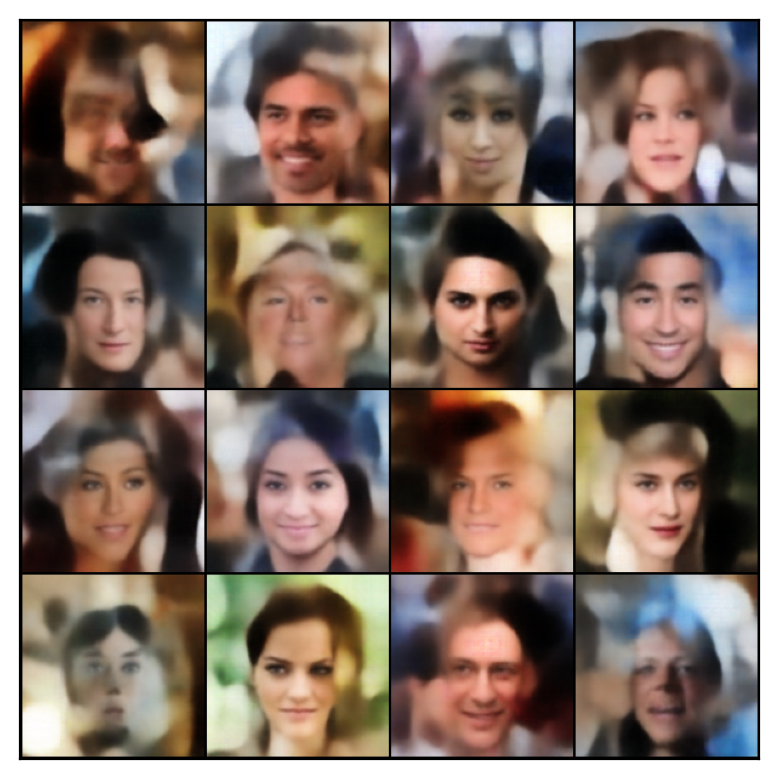

In [ ]:
sample = torch.randn(16, LATENT_DIM).to(device)
sample = model.decode(sample).cpu()
sample = sample.view(16, 3, *IMAGE_SIZE)
# save_image(sample, "filename.png")

grid_img = make_grid(sample, nrow=4)
grid_img.shape, sample.shape
plt.imshow(grid_img.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
dataset = CelebADataset(
    annotations_file=folder + "identities.txt",
    img_dir=folder + "img",
    img_split_file=folder + "groups.txt",
    split="all",
    transform=celeb_transform,
)
loader = DataLoader(dataset=dataset, batch_size=1, shuffle=True)

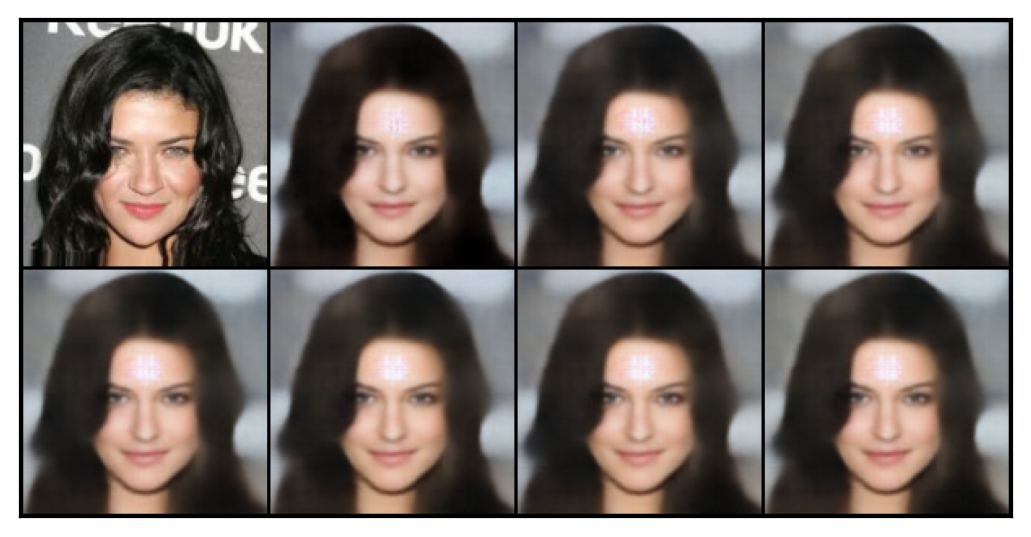

In [ ]:
for pic, _ in loader:
    pics = pic.to(device)
    break
orig = torch.clone(pics)

for _ in range(7):
    recon, _, _ = model(pics)
    pic = recon[0].view(1, 3, *IMAGE_SIZE)
    pics = torch.cat((pics, pic), dim=0)

# save_image(pics, 'rndpics.jpg', nrow=8)

grid_img = make_grid(pics.cpu(), nrow=4)
grid_img.shape, sample.shape
plt.imshow(grid_img.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

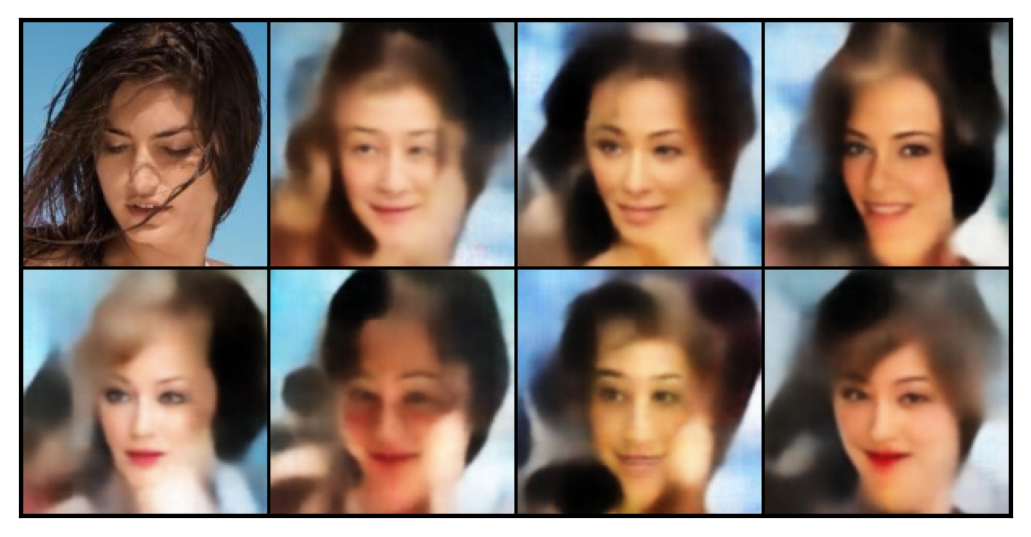

In [ ]:
for pic, _ in loader:
    pics = pic.to(device)
    break
orig = torch.clone(pics)

mu, log_var = model.encode(orig)

for _ in range(7):
    w = 1e-11
    std = torch.exp(w * log_var)
    eps = torch.randn_like(std)
    z = eps * std + mu
    recon = model.decode(z)
    pic = recon[0].view(1, 3, *IMAGE_SIZE)
    pics = torch.cat((pics, pic), dim=0)

# save_image(pics, 'rndpics.jpg', nrow=8)

grid_img = make_grid(pics.cpu(), nrow=4)
grid_img.shape, sample.shape
plt.imshow(grid_img.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()

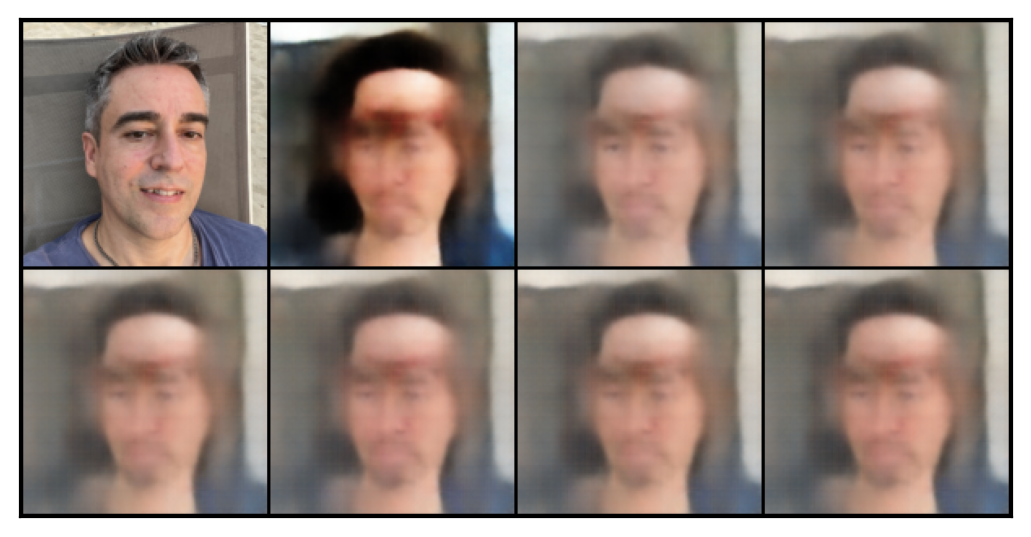

In [ ]:
image = Image.open("gabriel.jpeg")
# plt.imshow(image)

img_norm = celeb_transform(image)
# plt.imshow(img_tensor)

img_tensor = v2.PILToTensor()(img_norm)
img_tensor = v2.ToDtype(torch.float32, scale=True)(img_tensor)
img_tensor = torch.unsqueeze(img_tensor, 0)
# plt.imshow(img_tensor.permute(1, 2, 0))

pics = img_tensor.to(device)
orig = torch.clone(pics)

for _ in range(7):
    recon, _, _ = model(pics)
    pic = recon[0].view(1, 3, *IMAGE_SIZE)
    pics = torch.cat((pics, pic), dim=0)

# save_image(pics, 'rndpics.jpg', nrow=8)

grid_img = make_grid(pics.cpu(), nrow=4)
plt.imshow(grid_img.permute(1, 2, 0))
plt.xticks([])
plt.yticks([])
plt.show()